# Load Libraries

In [ ]:
# Import necessary libraries
import pandas as pd  # Library for data manipulation and analysis
import numpy as np  # Library for numerical computing
import glob  # Library for file handling
import re  # Library for regular expressions
from tqdm import tqdm  # Library for creating progress bars

import plotly.graph_objects as go  # Library for creating interactive plots

# Preprocessing
from sklearn import preprocessing  # Library for data preprocessing
import keras  # Deep learning library
from keras.models import Sequential  # Sequential model for stacking layers
from keras.layers.core import Dense, Dropout, Activation  # Layers for fully connected neural networks
from keras.layers import LSTM  # LSTM layer for sequence modeling
from keras.models import load_model  # Loading pre-trained models
import matplotlib.pyplot as plt  # Library for basic data visualization
import h5py  # Library for handling large datasets
import datetime  # Library for date and time operations
import tensorflow as tf  # Deep learning library



In [ ]:
import tensorflow as tf  # Import the TensorFlow library
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Print the number of available GPUs

In [ ]:
# These lines use the glob module to find all file paths that match the pattern 'GreenD_reduced_version_03/*.csv'. 
# The resulting file paths are stored in path_lists.
# Then, the file paths are sorted alphabetically and assigned to sorted_file_paths
path_lists = glob.glob('GreenD_reduced_version_03/'+'*.csv')
sorted_file_paths = sorted(path_lists)


# This code defines a function extract_digits that takes a string as input and 
# uses regular expressions (re.findall()) to extract digits from the string. 
# It returns the extracted digits as an integer if they exist, otherwise it returns 0.
# Then, the sorted() function is used with key=extract_digits to sort the file
# paths based on the digits extracted from each path. Finally, the sorted file paths are printed
def extract_digits(string):
    # Extract digits from the string using regular expression
    digits = re.findall(r'\d+', string)
    return int(digits[0]) if digits else 0

sorted_file_paths = sorted(path_lists, key=extract_digits)
print(sorted_file_paths)


# In this block of code, an empty list conct_list is created. Then, a loop is executed over each sorted
# file path using sorted_file_paths. Inside the loop, each CSV file is read using pd.read_csv(),
# and the 'Timestamp' column is converted to a datetime object using pd.to_datetime() w
# ith the utc=True parameter and unit='s' to indicate that the values are in Unix timestamp format. 
# The 'Timestamp' column is then formatted to a specific string format '%Y-%m-%d %H:%M:%S' 
# using the dt.strftime() function. The resulting dataframe is appended to the conct_list

conct_list = []
for path in tqdm(sorted_file_paths ,desc='processing'):
    
    data = pd.read_csv(path)
    data['Timestamp'] = pd.to_datetime(data['Timestamp'],utc=True,unit='s')#format='%Y-%m-%d %H-%M-%S')
    data['Timestamp'] = data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    conct_list.append(data)
    
# The !mkdir command creates a directory named 'Combined-Dataset-version-03' 
# if it doesn't already exist. Then, pd.concat() is used to concatenate all 
# the dataframes in conct_list along the rows, creating a single combined dataframe named df
!mkdir 'Combined-Dataset-version-03'
df = pd.concat(conct_list)



In [ ]:
df.sort_values(by='Timestamp',inplace=True)
# This line of code sorts the DataFrame df based on the values in the 'Timestamp' column in ascending order. 
# The sort_values() function is used to perform the sorting operation. The by parameter specifies 
# the column to sort by, which in this case is 'Timestamp'. The inplace=True parameter is
# used to modify the DataFrame df in place, meaning the changes are applied directly to the DataFrame instead of creating a new sorted DataFrame

In [ ]:
import os

In [ ]:
os.makedirs('Concatenated_data',exist_ok=True)
df.to_csv('Concatenated_data/Whole_data.csv',index=False)

In [ ]:
import pandas as pd

def perform_downsampling(data, freq, aggregation_func='sum'):
    # Create a copy of the original data to avoid modifying it directly
    df = data.copy()

    # Check if 'Timestamp' column is already a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        # Convert 'Timestamp' column to datetime index
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df.set_index('Timestamp', inplace=True)

    # Downsample the DataFrame to the specified frequency and apply the aggregation function
    downsampled_df = df.resample(freq).agg(aggregation_func)

    # Fill missing values using forward fill
    downsampled_df.fillna(method='ffill', inplace=True)

    # Reset the index of the downsampled DataFrame
    downsampled_df.reset_index(inplace=True)

    return downsampled_df


In [ ]:
# Assuming you have your DataFrame named 'df'

# Downsample the DataFrame to 1-hour frequency and aggregate using sum
hourly_df = perform_downsampling(df, freq='1H')

# Downsample the DataFrame to daily frequency (24 hours) and aggregate using sum
daily_df = perform_downsampling(df, freq='24H')


In [ ]:
hourly_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your time series data is stored in a DataFrame with a column named 'Timestamp' and a column named 'Value'
# Set the 'Timestamp' column as the index of the DataFrame if it's not already set

# Perform seasonal decomposition
result = seasonal_decompose(hourly_df['Summe'], model='additive', period=24*150)

# Access the trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series and the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(hourly_df['Summe'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [ ]:
from utils.visualization import plot
plot(hourly_df,x_feature_name='Timestamp',y_feature_name='Summe',title='Sampling Frequency 1 Hours')



In [46]:
hourly_df

,Timestamp,Summe
0,2014-03-12 07:00:00,4509.855863
1,2014-03-12 08:00:00,9989.721488
2,2014-03-12 09:00:00,18400.781111
3,2014-03-12 10:00:00,10040.451500
4,2014-03-12 11:00:00,18893.909108
...,...,...
11386,2015-06-29 17:00:00,38119.818093
11387,2015-06-29 18:00:00,26577.352951
11388,2015-06-29 19:00:00,23695.189477
11389,2015-06-29 20:00:00,31168.580645


# BiDirectional LSTM Model Development Demo 

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load the data
data = pd.read_csv('Concatenated_data/Whole_data.csv')

# Preprocess the data
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data = data.set_index('Timestamp')

# Create the input and output sequences
input_seq = []
output_seq = []

# Convert data to numpy array
values = data['Summe'].values

# Number of previous days used as input
num_input_days = 3

# Number of future hours to forecast
num_forecast_hours = 24

# Create the input and output sequences
for i in range(num_input_days, len(values) - num_forecast_hours):
    input_seq.append(values[i - num_input_days:i])
    output_seq.append(values[i:i + num_forecast_hours])

# Convert the input and output sequences to numpy arrays
input_seq = np.array(input_seq)
output_seq = np.array(output_seq)

# Normalize the data
scaler = MinMaxScaler()
input_seq = scaler.fit_transform(input_seq)
output_seq = scaler.fit_transform(output_seq)

# Split the data into training and testing sets
train_input, test_input, train_output, test_output = train_test_split(input_seq, output_seq, test_size=0.2, shuffle=False)

# Reshape the input sequences to 3D arrays
train_input = train_input.reshape(-1, num_input_days, 1)
test_input = test_input.reshape(-1, num_input_days, 1)

# Define the parameters
timesteps_per_day = num_input_days * 24
past_input_timesteps = num_input_days
batch_size = 64
epochs = 75
steps_per_epoch = 200
lstm_units = 200
dense_units = 130
learning_rate = 0.001

# Build the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=(past_input_timesteps, 1)))
model.add(Flatten())
model.add(Dense(dense_units, activation='relu'))
model.add(Dense(num_forecast_hours, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(train_input, train_output,verbose=2 ,epochs=epochs, batch_size=batch_size, steps_per_epoch=steps_per_epoch, validation_data=(test_input, test_output))

# Evaluate the model
loss = model.evaluate(test_input, test_output)
print('Test Loss:', loss)


2023-06-25 16:47:04.457699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 16:47:04.459973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 16:47:04.460869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/75


2023-06-25 16:47:06.809048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-25 16:47:06.810481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-25 16:47:06.812059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 - 55s - loss: 8.9524e-04 - val_loss: 7.7249e-04 - 55s/epoch - 277ms/step
Epoch 2/75
200/200 - 50s - loss: 7.3562e-04 - val_loss: 7.9271e-04 - 50s/epoch - 248ms/step
Epoch 3/75
200/200 - 49s - loss: 8.4926e-04 - val_loss: 7.1958e-04 - 49s/epoch - 243ms/step
Epoch 4/75
200/200 - 50s - loss: 8.4962e-04 - val_loss: 7.4465e-04 - 50s/epoch - 249ms/step
Epoch 5/75
200/200 - 49s - loss: 8.4449e-04 - val_loss: 7.6891e-04 - 49s/epoch - 245ms/step
Epoch 6/75
200/200 - 49s - loss: 8.7866e-04 - val_loss: 8.2306e-04 - 49s/epoch - 247ms/step
Epoch 7/75
200/200 - 49s - loss: 8.4706e-04 - val_loss: 7.2524e-04 - 49s/epoch - 247ms/step
Epoch 8/75
200/200 - 51s - loss: 7.6516e-04 - val_loss: 7.1819e-04 - 51s/epoch - 253ms/step
Epoch 9/75
200/200 - 56s - loss: 7.4666e-04 - val_loss: 7.4155e-04 - 56s/epoch - 278ms/step
Epoch 10/75
200/200 - 53s - loss: 7.9299e-04 - val_loss: 7.4679e-04 - 53s/epoch - 265ms/step
Epoch 11/75
200/200 - 54s - loss: 7.4349e-04 - val_loss: 7.7715e-04 - 54s/epoch - 269ms/st

In [60]:
test = test_input[0:50]

In [61]:
test_o = test_output[0:50]

In [ ]:
for 

2/2 [==============================] - 0s 3ms/step


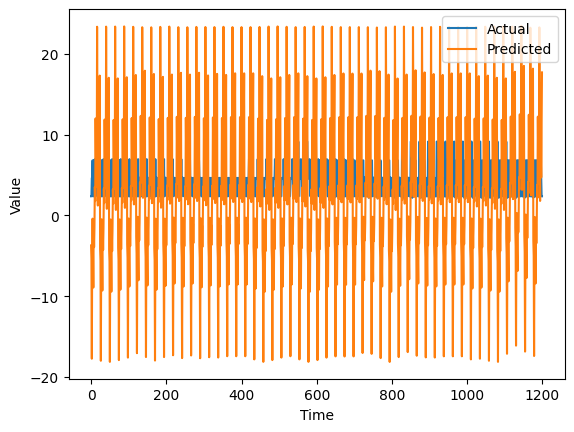

In [62]:

# Make predictions on the test set
predictions = model.predict(test)

# Denormalize the predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(test_o)

# Plot the actual and predicted values
plt.plot(actual_values.flatten(), label='Actual')
plt.plot(predictions.flatten(), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [41]:

# Generate sample input data
num_samples = 1000
input_data = np.random.rand(num_samples, past_input_timesteps * timesteps_per_day, 1)

# # Generate sample output data
# output_data = np.random.rand(num_samples, 24)

# # Split the data into training and testing sets
# train_samples = int(0.8 * num_samples)
# train_input = input_data[:train_samples]
# train_output = output_data[:train_samples]
# test_input = input_data[train_samples:]
# test_output = output_data[train_samples:]

# # Train the model
# model.fit(train_input, train_output, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch)

# # Make predictions on the test set
# predictions = model.predict(test_input)

# # Plot the actual and predicted values
# num_plots = 5  # Number of plots to display
# plot_indices = np.random.choice(test_input.shape[0], num_plots, replace=False)  # Randomly select indices for plotting

# fig, axes = plt.subplots(num_plots, figsize=(10, 6*num_plots))

# for i, idx in enumerate(plot_indices):
#     ax = axes[i]
#     ax.plot(range(24), test_output[idx], label='Actual')
#     ax.plot(range(24), predictions[idx], label='Predicted')
#     ax.set_xlabel('Hour')
#     ax.set_ylabel('Value')
#     ax.set_title(f'Actual vs. Predicted - Sample {idx+1}')
#     ax.legend()

# plt.tight_layout()
# plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [ ]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

def create_dataset(dataset, look_back=30, predict_next=24):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - predict_next):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        b = dataset[i+look_back:i+look_back+predict_next, 0]
        dataY.append(b)
        
    return np.array(dataX), np.array(dataY)



In [ ]:
sub_sample = hourly_df.iloc[0:5000]

In [ ]:

# These lines perform feature scaling on the 'Summe' column of the DataFrame data_df 
# using Min-Max scaling. It creates an instance of MinMaxScaler and fits it to the data, 
# transforming the values to the range [0, 1]. The scaled data is assigned to the variable dataset
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(sub_sample['Summe'].values.reshape(-1, 1))


In [ ]:

# split into train, validation, and test sets
# These lines split the dataset into train, validation, and test sets based on specified proportions.
# It calculates the sizes of each set and assigns the corresponding subsets of dataset to train_data, val_data, and test_data
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

train_data = dataset[:train_size]
test_data = dataset[train_size:]


In [ ]:

# create train, validation, and test datasets
# These lines call the create_dataset function to create input-output pairs for the train, validation, 
# and test sets. The function takes the respective subsets of data (train_data, val_data, test_data) 
# and a look_back parameter, and returns input (x) and output (y) sequences. 
# The input-output pairs are assigned to x_train, y_train, x_val, y_val, x_test, and y_test
look_back = 500
x_train, y_train = create_dataset(train_data, look_back)
# x_val, y_val = create_dataset(val_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)



In [ ]:

# reshape the input data
# These lines reshape the input sequences (x_train, x_val, x_test) to match the required input shape for the LSTM model. 
# The new shape is (batch_size, timesteps, features), where batch_size is the number of samples,
# timesteps is the number of time steps, and features is the number of features.
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
# x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# print the sizes of the datasets
print('Training Data Size:', x_train.shape)
# print('Validation Data Size:', x_val.shape)
print('Testing Data Size:', x_test.shape)


# Model Building | Fitting

In [ ]:

# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available.")
    print("List of physical GPUs:")
    for device in physical_devices:
        print(device)
else:
    print("GPU is not available. Using CPU instead.")
    
    
# Summary:
# The code checks if a GPU is available and sets the memory growth option if it is.
# It then prints the availability and a list of physical GPUs if present
# . If no GPU is available, it prints a message indicating the use of the CPU instead.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Set the model parameters
num_epochs = 200
batch_size = 128
num_layers = 4
input_window =1000
look_back = 1000

# Create the LSTM model
model = Sequential()
model.add(LSTM(input_window, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(800,activation='tanh', return_sequences=True))
model.add(LSTM(500,activation='tanh', return_sequences=True))
model.add(LSTM(300,activation='tanh', return_sequences=True))
model.add(LSTM(200,activation='tanh', return_sequences=True))

model.add(Dense(1))
# Compile the model with a custom learning rate
learning_rate = 0.001  # Change this value to your desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Compile the model
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=optimizer)

# Get the model's parameters
model_params = model.count_params()

# Create the model name based on parameters and training settings
model_name = f"model_{num_epochs}_epochs_{batch_size}_batch_{num_layers}_layers_{model_params}_params_input_window_{input_window}"

# Define early stopping callback
early_stopping = EarlyStopping(patience=10, monitor='loss', restore_best_weights=True)

# Define TensorBoard callback with model-specific log folder
tb_callback = TensorBoard(log_dir=f'logs/{model_name}/', write_graph=False, update_freq='epoch')

# Define model checkpoint callback with model-specific filename
checkpoint_callback = ModelCheckpoint(f'checkpoints/{model_name}_{{epoch:02d}}.h5', save_weights_only=True, save_best_only=True)

# Train the model with early stopping, checkpoints, and TensorBoard
history = model.fit(x_train, y_train, #validation_data=(x_val, y_val), 
                    epochs=num_epochs, 
                    batch_size=batch_size, 
                    verbose=1,
                    callbacks=[early_stopping, 
                               tb_callback, 
                               checkpoint_callback])



In [ ]:
# Print model summary
print(model.summary())


In [ ]:
import matplotlib.pyplot as plt

# Get the training and validation loss values from the history object
# These lines extract the training loss and validation loss values from the history object, which was obtained during the model training.
train_loss = history.history['loss']
# val_loss = history.history['val_loss']
 
# Plot the training loss and validation loss
# These lines create line plots for the training loss and validation loss values. The plot function is used to plot the values on a graph.
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# These lines set the labels for the x-axis and y-axis, title of the plot, and enable the legend to display the labels of the plotted lines.
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
# Summary:
# The code visualizes the training and validation loss values obtained during the model training. It plots the training loss and validation loss on the same graph, with the x-axis representing the epochs and the y-axis representing the loss values. The plot provides insights into the performance of the model over the training epochs, showing how the loss values change over time.

In [ ]:
current_input = x_train[-1].reshape(1, 1, 1000)
predictions = []
inverse_prediction_list = []

for _ in range(100):
    predicted = model.predict(current_input)
    inverse_prediction = min_max_scaler.inverse_transform(predicted.reshape(-1, 1))
    inverse_prediction_list.append(inverse_prediction.reshape(-1,1)[0][0])
    predictions.append(predicted[0, -1, 0])
    
    # Update the input for the next step
    current_input[0, :, :-1] = current_input[0, :, 1:]
    current_input[0, :, -1] = predicted[0, -1, 0]
    
    # print("Prediction:")
    # print(predicted)
    # print("Current input:")
    # print(current_input.reshape(-1, 1))
    
# Remove the first value from predictions
# predictions = predictions[1:]
inverse_prediction_list

In [ ]:
plt.plot(min_max_scaler.inverse_transform(test_data).reshape(-1,1).flatten().tolist()[0:100])
plt.plot(inverse_prediction_list)

In [ ]:
x_test

In [ ]:
current_input = x_test[-1].reshape(1, 1, 1000)
predictions = []
inverse_prediction_list = []

for _ in range(100):
    predicted = model.predict(current_input)
    inverse_prediction = min_max_scaler.inverse_transform(predicted.reshape(-1, 1))
    inverse_prediction_list.append(inverse_prediction.reshape(-1,1)[0][0])
    predictions.append(predicted[0, -1, 0])
    
    # Update the input for the next step
    current_input[0, :, :-1] = current_input[0, :, 1:]
    current_input[0, :, -1] = predicted[0, -1, 0]
    
    # print("Prediction:")
    # print(predicted)
    # print("Current input:")
    # print(current_input.reshape(-1, 1))
    
# Remove the first value from predictions
# predictions = predictions[1:]
inverse_prediction_list

In [ ]:
# plt.plot(min_max_scaler.inverse_transform(test_data).reshape(-1,1).flatten().tolist()[0:100])
plt.plot(inverse_prediction_list)

In [ ]:
current_input[0][1:]

In [ ]:
import numpy as np

def forecast_multi_step(model, test_data, lookback_window, num_steps, scaler):
    forecasts = []
    
    for step in range(0, len(test_data) - num_steps + 1):
        input_data = test_data[step:step + lookback_window]
        scaled_input = scaler.transform(input_data)
        
        # Reshape the input data to match the model's input shape
        reshaped_input = scaled_input.reshape(1, lookback_window, 1)
        
        # Make the prediction for each step
        predictions = []
        with_prediction = []
        for i in range(num_steps):
            prediction = model.predict(reshaped_input)
            print(prediction)
            with_prediction.append(scaler.inverse_transform(predictions.reshape(-1,1)))
            predictions.append(prediction[0, -1, 0])
            
            # Update the input data for the next step
            reshaped_input = np.roll(reshaped_input, -1, axis=1)
            reshaped_input[0, -1, 0] = scaler.transform([[predictions[-1]]])
        
        # Inverse transform the predictions
        predictions = scaler.inverse_transform(predictions)
        
        # Append the inverse transformed predictions to the forecasts list
        forecasts.extend(predictions)
    
    return with_prediction


lookback_window = 20
num_steps = 24

forecasts = forecast_multi_step(model, test_data, lookback_window, num_steps, min_max_scaler)

print("Multi-step forecasts:")
print(forecasts)





In [ ]:
forecasts.reshape(-1,1)

In [ ]:
min_max_scaler.inverse_transform(forecasts.reshape(-1,1))

# Saving the Model 

In [ ]:
try:
    import joblib
except:
    !pip install joblib
    import joblib
    # Save the model
joblib.dump(model, 'model.pkl')
# Load the model
loaded_model = joblib.load('model.pkl')



In [ ]:
import numpy as np
import pickle
import os

def load_model_and_scaler(model_path=None, scaler_path=None):
    # Use default paths if not provided
    model_path = model_path# or MODEL_PATH
    scaler_path = scaler_path #or SCALER_PATH

    # Load the model from the .pkl file
    with open(model_path, 'rb') as file:
        loaded_model = pickle.load(file)

    # Load the scaler from the .pkl file
    with open(scaler_path, 'rb') as file:
        scaler = pickle.load(file)

    return loaded_model, scaler


def predict_next_points(model_path, scaler_path, input_data, num_predictions=24):
    """
    Predicts the next points in a sequence using the provided model.

    Args:
        model_path (str): Path to the saved model file (.pkl).
        scaler_path (str): Path to the saved scaler file (.pkl).
        input_data (ndarray): Input sequence of points.
        num_predictions (int): Number of points to predict. Default is 24.

    Returns:
        ndarray: Predicted sequence of points.
    """

    # Load the model from the .pkl file
    with open(model_path, 'rb') as file:
        loaded_model = pickle.load(file)

    # Load the scaler from the .pkl file
    with open(scaler_path, 'rb') as file:
        scaler = pickle.load(file)

    # Reshape the input data
    input_data = np.array(input_data).reshape(1, 1, -1)

    # Predict the next points iteratively
    predictions = []
    for _ in range(num_predictions):
        # Predict the next point
        next_point = loaded_model.predict(input_data)[:, -1, 0]
        predictions.append(next_point)

        # Append the predicted point to the input data
        input_data = np.append(input_data[:, :, 1:], next_point.reshape(1, 1, 1), axis=2)

    # Rescale the predicted values
    rescaled_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Return the rescaled predicted sequence of points
    return rescaled_predictions


# Example usage

# Assuming you have a trained model and a scaler object
model = model
scaler = min_max_scaler

# Assuming you have the input data
input_data = np.array([1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21])

# Saving the model and scaler
folder_name = 'model_files'
save_model_and_scaler(model, scaler)

# Predicting the next points and rescaling
predicted = predict_next_points(
    os.path.join(folder_name, 'model.pkl'),
    os.path.join(folder_name, 'scaler.pkl'),
    input_data
)

# Printing the rescaled predictions
print(predicted)


In [ ]:
predicted

In [ ]:
loaded_model = joblib.load('model.pkl')
loaded_model.summary()

# Testing Data

In [ ]:
# These lines calculate the predictions (y_hat) using the trained model on the test data (x_test). 
# Then, the inverse transform is applied to y_hat and y_test using the min_max_scaler to obtain the actual
# values in their original scale. The predicted values (y_hat_inversed) and actual 
# values (y_test_inversed) are converted to flat list
Results_test = {}
y_hat = model.predict(x_test)
y_hat_inversed = min_max_scaler.inverse_transform(y_hat.reshape(-1,1)).flatten().tolist()
y_test_inversed = min_max_scaler.inverse_transform(y_test.reshape(-1,1)).flatten().tolist()

# These lines create a dictionary Results_test to store the predicted values, actual values, and index values.
# The predicted and actual values are assigned to the corresponding keys, and the index values are generated using np.arange()
Results_test['y_hat'] =y_hat_inversed
Results_test['y_test'] =y_test_inversed
Results_test['Index'] = np.arange(0, len(y_test_inversed))

# These lines create a DataFrame results_df_test from the Results_test dictionary. The DataFrame is then displayed.
results_df_test = pd.DataFrame.from_dict(Results_test)
display(results_df_test)


# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df_test['Index'], y=results_df_test['y_hat'], name='Predicted',mode='markers+lines'))
fig.add_trace(go.Scatter(x=results_df_test['Index'], y=results_df_test['y_test'], name='Actual' ,mode='markers+lines'))
fig.update_layout(
            xaxis_title='Index',
            yaxis_title='Value',
            title='Tesing Data Predicted vs Actual Curves'
        )
fig.write_html('plots/LSTM-predicted_actual_curves.html')

fig.show()

# Summary:
# The code calculates the predictions of the LSTM model on the test data and transforms them back to their original scale.
# It creates a DataFrame to store the predicted and actual values along with their corresponding indices. 
# Then, it generates a plot using Plotly with separate lines for the predicted and actual values.
# The plot is saved as an HTML file and displayed. 
# This allows visual comparison between the predicted and actual values of the testing data.

In [ ]:
results_df_test

In [ ]:
results_df_test.plot(x='Index',y='y_hat')

In [ ]:
results_df_test.plot(x='Index',y='y_test')

In [ ]:

Results_train = {}

# for Training data 
y_train_hat = model.predict(x_train)
y_train_hat_inversed = min_max_scaler.inverse_transform(y_train_hat.reshape(-1,1)).flatten().tolist()
y_train_inversed = min_max_scaler.inverse_transform(y_train.reshape(-1,1)).flatten().tolist()

Results_train['y_train_hat'] =y_train_hat_inversed
Results_train['y_train'] =y_train_inversed
Results_train['Index'] = np.arange(0, len(y_train_inversed))
results_df_train = pd.DataFrame.from_dict(Results_train)
display(results_df_train)



# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=results_df_train['Index'], y=results_df_train['y_train_hat'], name='Predicted',mode='markers+lines'))
fig.add_trace(go.Scatter(x=results_df_train['Index'], y=results_df_train['y_train'], name='Actual' ,mode='markers+lines'))
fig.update_layout(
            xaxis_title='Index',
            yaxis_title='Value',
            title='Tesing Data Predicted vs Actual Curves'
        )
fig.write_html('plots/LSTM-predicted_actual_curves.html')
fig.show()

# Summary:
# The code calculates the predictions of the LSTM model on the training data and transforms them back to their original scale. 
# It creates a DataFrame to store the predicted and actual values along with their corresponding indices 
# for the training data. Then, it generates a plot using Plotly with separate lines for the predicted and actual values. 
# The plot is saved as an HTML file and displayed. This allows visual comparison between the predicted and actual 
# values of the training data.

In [ ]:
results_df_test

In [ ]:
import numpy as np

def calculate_errors(predicted, actual):
    # Convert lists to numpy arrays
    predicted = np.array(predicted)
    actual = np.array(actual)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(predicted - actual))

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))

    # Mean Squared Error (MSE)
    mse = np.mean((predicted - actual) ** 2)

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return mae, rmse, mse, mape
train_mae , train_rmse , train_mse,train_mape = calculate_errors(results_df_train['y_train_hat'],results_df_train['y_train'])
test_mae , test_rmse , test_mse,test_mape = calculate_errors(results_df_test['y_hat'],results_df_test['y_test'])

print('Results on Training Data')
print(f'MAE : {train_mae}\nRMSE : {train_rmse}\nMSE : {train_mse}\nMAPE : {train_mape}'.format())
print('\n')
print('Results on Testing Data')
print(f'MAE : {test_mae}\nRMSE : {test_rmse}\nMSE : {test_mse}\nMAPE : {test_mape}')

# Summary:
# The code defines a function to calculate various error metrics (MAE, RMSE, MSE, MAPE) given predicted and actual values.
# Then, the function is called to calculate the error metrics for both the training and testing data. 
# The calculated error metrics provide a quantitative assessment of the model's performance in terms of the prediction accuracy.

In [ ]:
import pandas as pd

# Read the existing error history DataFrame from CSV
error_history = pd.read_csv('errorDatabaseHistory.csv')

# Create a new record as a DataFrame
new_record = pd.DataFrame({
    'modelName': [model_name],
    'modelConfig': [model.get_config()],
    'train_rmse': [train_rmse],
    'train_mae': [train_mae],
    'train_mse': [train_mse],
    'train_mape': [train_mape],
    'test_rmse': [test_rmse],
    'test_mae': [test_mae],
    'test_mse': [test_mse],
    'test_mape': [test_mape]
})

# Append the new record to the existing error history DataFrame
error_history = pd.concat([error_history, new_record], ignore_index=True)

# Save the updated error history DataFrame to CSV
error_history.to_csv('errorDatabaseHistory.csv', index=False)


# Final

In [ ]:
error_history.iloc[7][0]